# Variational Quantum Eigensolver for Arbitraty Matrix

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
from qiskit.circuit.library import NormalDistribution
from math import pi
from qiskit import *
from qiskit.visualization import plot_histogram
import itertools
import scipy.special
import scipy

## Test Matrices

Here are listed the matrices for which we will test the efficiency of the Variational Quantum Eigensolver. 

In [2]:
# Dictionary Definition for Pauli Matrices

Pauli = {
    'I' : np.array([[1,0+0.j],[0+0.j,1]]),
    'X' : np.array([[0+0.j,1],[1,0+0.j]]),
    'Y' : np.array([[0,-1j],[1j,0]]),
    'Z' : np.array([[1,0+0.j],[0+0.j,-1]])
}

# This is the basis of Pauli matrices used for decomposition
basis = ['X', 'Y', 'Z']

In [3]:
Hami_1 = np.array([
    [1,0,0,0],
    [0,0,-1,0],
    [0,-1,0,0],
    [0,0,0,1]
])

Hami_2 = 3*np.kron(np.kron(Pauli['Y'],Pauli['X']),Pauli['Z']) + 2*np.kron(np.kron(Pauli['X'],Pauli['X']),Pauli['X'])  + 1*np.kron(np.kron(Pauli['Z'],Pauli['Z']),Pauli['X'])

print('First Example (4x4) : \n',Hami_1)
print('Second Example (8x8) : \n',Hami_2)

First Example (4x4) : 
 [[ 1  0  0  0]
 [ 0  0 -1  0]
 [ 0 -1  0  0]
 [ 0  0  0  1]]
Second Example (8x8) : 
 [[ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-3.j  2.+0.j]
 [ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+3.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.-3.j  2.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j  2.+0.j  0.+3.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+3.j  2.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  2.+0.j  0.-3.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+3.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j]
 [ 2.+0.j  0.-3.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j]]


### Decomposition of Arbitraty Unitary Matrix 

The decomposition of an arbitrary Unitary Matrix $$M_{N \times N} $$ (with N being a power of 2) is done in the following steps:
- First the basis set of all the Kronecker products of Pauli matrices is generated and stored
- A least squares minimization fitting is applied 

This last point probably restricts the applicability of the method to any randomly generated unitary matrix, but for the ones tested it worked properly. 

In [5]:
# Here all the products are generated
def generate_ops(nqb):
    
    products = {}    
    
    M = np.zeros((2**nqb, 2**nqb, 3*(3**(nqb-1))+1), dtype = complex)
    count = 0
    
    
    for i in itertools.product(basis, repeat = nqb):
        a = list(i)
        index1 = ''
        for j in range(len(a)):
            if j == 0:
                Op1 = np.kron(1, Pauli[a[j]])
                Op2 = np.kron(Op1, Pauli[a[j+1]])
            elif j < len(a)-1:
                Op1 = Op2
                Op2 = np.kron(Op1, Pauli[a[j+1]])
            index1 += str(a[j])
            
        products[index1] = Op2   
        M[:,:,count] = Op2
        count += 1
    
    products['I'*nqb] = np.identity((2**nqb),dtype = complex)
    M[:,:,M.shape[2]-1] = np.identity((2**nqb),dtype = complex)
    
    return M, products

In [6]:
# Here the matrix is decomposed in the basis of matrices previously defined

def decomposition(A, nqb):
    
    M, prod = generate_ops(nqb)
    ND = M.shape[0]*M.shape[0]
    ndim = M.shape[0]
    a=np.zeros((2*ND,M.shape[2]), dtype = complex)
    b=np.zeros((2*ND,), dtype = complex)
    
    i=0
    j=0
    for m in range(ndim):
        for m1 in range(ndim):
            b[j] = A[m,m1]
            j+=1
    
    
    for i in range(M.shape[2]):
        j=0
        for m in range(ndim):
            for m1 in range(ndim):    
                a[j,i] = M[m,m1,i]
                j+=1           
        i+=1      
    
    x,resid,rank,s = np.linalg.lstsq(a,b)
    
    return x, resid, prod

## Hamiltonian Definition

The Hamiltonian definition is nothing but taking the coefficients of the non zero decomposed operators and storing them in a dictionary. 

- I.e. we will have something like { 'XX' : 1, 'YY' : 1 , 'ZZ' : -2} if $$ H = XX + YY -2ZZ$$

Instead, the 'total_energy' function takes the results from the VQE steps and multiplies, for each operator coefficient, the count results

- I.e. we will have something like 'XX' (counts) = 0.5 -> $$ \langle XX \rangle = 1 \times 0.5 $$

In [9]:
def hamiltonian(A,nqb):
    
    ham = {}

    x,resid, prod = decomposition(A,nqb)
    x = np.round_(x,decimals = 2)
    for i in range(len(x)):   
        if x[i] != 0:
            print('{}\t: {}'.format(list(prod.keys())[i],x[i]))
            ham[list(prod.keys())[i]] = x[i]
            
    return ham

def total_energy(H,results,nqb):
    
    ops = list(H.keys())
    
    energy = 0
    for operators in ops:
        if operators == 'I'*nqb:
            energy += 1*H[operators]       
        else:
            energy += results[operators]*H[operators]
        
    return energy

### Measurements Definitions

The measurements for the X, Y and Z operators are defined here. A final Z measurement has to be applied to the X and Y ones. 

In [8]:
def z_measurement(qc,q,c,nqb):
    
    for i in reversed(range(nqb-1)):
        qc.cx(q[i],q[nqb-1])
    qc.measure(q[nqb-1],c[0])
    
    return qc

def x_measurement(qc,q,qb1):
    
    qc.h(q[qb1])        
    
    return qc

def y_measurement(qc,q,qb1):
    
    #qc.s(q[qb1])
    qc.sdg(q[qb1])
    qc.h(q[qb1])  
    
    return qc

### Ansatz Definitions

Two types of ansatz are employed, one linear and one fully entangled

In [10]:
def ansatz_linear(qc, q, nqb, theta):
    
    for i in range(nqb):
        qc.ry(theta[i],q[i])
        qc.rz(theta[i+nqb],q[i])
    j = 0
    while j < nqb-1:
            qc.cx(q[j],q[j+1])
            j +=1
    for i in range(nqb):
        qc.ry(theta[i+2*nqb],q[i])
        qc.rz(theta[i+3*nqb],q[i])    
        
def ansatz_full_ent(qc, q, nqb, theta):
    
    for i in range(nqb):
        qc.ry(theta[i],q[i])
        qc.rz(theta[i+nqb],q[i])
    for i in range(nqb-1):
        j = i
        while j < (nqb-1):
            qc.cx(q[i],q[j+1])
            j+=1
    for i in range(nqb):
        qc.ry(theta[i+2*nqb],q[i])
        qc.rz(theta[i+3*nqb],q[i])    
        

# VQE Single Step

Here is where the fun happens, but this function unfortunately has way too many parameters to be passed to a optimizer, therefore another preliminary step is needed. 

In [16]:
def vqe_step(A, nqb, theta, ansatz,verbose = True):  
    
    # 4 paramters required: 
    # Te matrix to be decomposed A, the number of qubits nqb, the vector of angles and the type of Ansatz
    
    shots = 8000
    results_vqe = dict()
    qc_list = dict()
    
    H = hamiltonian(A,nqb)
    ops = list(H.keys())
    
    for operators in ops:
        
        q = QuantumRegister(nqb)
        c = ClassicalRegister(1)
        qc = QuantumCircuit(q,c)
            
        if ansatz == 'linear':
            ansatz_linear(qc,q,nqb,theta)
            qc.barrier()
        elif ansatz == 'full_ent':
            ansatz_full_ent(qc,q,nqb,theta)
            qc.barrier()            
        
        for k in range(nqb):
            
            if operators[k] == 'X':
                
                x_measurement(qc,q,k)
                
            elif operators[k] == 'Y':
                
                y_measurement(qc,q,k) 
                
            elif operators[k] == 'I':
                
                results_vqe[operators] = mean
                qc_list[operators] = qc
                
        z_measurement(qc,q,c,nqb)
        
        qasm_sim = Aer.get_backend('qasm_simulator')
        qjob = assemble(qc, shots = shots)
        results = qasm_sim.run(qjob).result()
        counts = results.get_counts()

        if len(counts) == 1: 
            try:
                counts['0']
                mean = 1
            except:
                mean = -1
        else:
            mean = (counts['0']-counts['1'])/shots
            
        results_vqe[operators] = mean
        qc_list[operators] = qc
        
    energy = total_energy(H,results_vqe,nqb)
    
    if verbose: 
        print("Mean values from measurement results:\n", results_vqe) 
        print(f"\n{'Energy':<10}")
        print(f"{energy:<10f} ")
    
        return energy, qc_list
    
    else: 
        return energy.real

## Optimization  with COBYLA

The optimization procedure is done with the COBYLA optimizer provided by Qiskit

In [17]:
from qiskit.aqua.components.optimizers import COBYLA

### Example 1

In [19]:
# This is the function we will optimize 
def VQE(theta):
    
    energy, qc_list = vqe_step(Hami_1, 2, theta, ansatz = 'linear', verbose = True)
    
    return energy

optimizer = COBYLA(maxiter=1000, tol=0.01)
init = np.random.rand(8) 
Optimize_Eig = optimizer.optimize(num_vars=8, objective_function = VQE , initial_point=init)

<ipython-input-6-9df7e98972d8>:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x,resid,rank,s = np.linalg.lstsq(a,b)


XX	: (-0.5+0j)
YY	: (-0.5+0j)
ZZ	: (0.5-0j)
II	: (0.5-0j)
Mean values from measurement results:
 {'XX': 0.56225, 'YY': -0.3985, 'ZZ': 0.81425, 'II': 0.81225}

Energy    
0.825250+0.000000j 
XX	: (-0.5+0j)
YY	: (-0.5+0j)
ZZ	: (0.5-0j)
II	: (0.5-0j)
Mean values from measurement results:
 {'XX': 0.617, 'YY': -0.6365, 'ZZ': 0.967, 'II': 0.97625}

Energy    
0.993250+0.000000j 
XX	: (-0.5+0j)
YY	: (-0.5+0j)
ZZ	: (0.5-0j)
II	: (0.5-0j)
Mean values from measurement results:
 {'XX': 0.47025, 'YY': 0.1015, 'ZZ': 0.26075, 'II': 0.26325}

Energy    
0.344500+0.000000j 
XX	: (-0.5+0j)
YY	: (-0.5+0j)
ZZ	: (0.5-0j)
II	: (0.5-0j)
Mean values from measurement results:
 {'XX': -0.024, 'YY': 0.27325, 'ZZ': 0.34625, 'II': 0.34025}

Energy    
0.548500+0.000000j 
XX	: (-0.5+0j)
YY	: (-0.5+0j)
ZZ	: (0.5-0j)
II	: (0.5-0j)
Mean values from measurement results:
 {'XX': 0.15025, 'YY': 0.27525, 'ZZ': 0.50125, 'II': 0.4935}

Energy    
0.537875+0.000000j 
XX	: (-0.5+0j)
YY	: (-0.5+0j)
ZZ	: (0.5-0j)
II	: (0.5-0j)

Mean values from measurement results:
 {'XX': 0.984, 'YY': 0.9875, 'ZZ': -0.9815, 'II': -0.9815}

Energy    
-0.976500+0.000000j 
XX	: (-0.5+0j)
YY	: (-0.5+0j)
ZZ	: (0.5-0j)
II	: (0.5-0j)
Mean values from measurement results:
 {'XX': 0.98125, 'YY': 0.988, 'ZZ': -0.9715, 'II': -0.97625}

Energy    
-0.970375+0.000000j 
XX	: (-0.5+0j)
YY	: (-0.5+0j)
ZZ	: (0.5-0j)
II	: (0.5-0j)
Mean values from measurement results:
 {'XX': 0.987, 'YY': 0.9895, 'ZZ': -0.98075, 'II': -0.98375}

Energy    
-0.978625+0.000000j 
XX	: (-0.5+0j)
YY	: (-0.5+0j)
ZZ	: (0.5-0j)
II	: (0.5-0j)
Mean values from measurement results:
 {'XX': 0.98, 'YY': 0.99575, 'ZZ': -0.985, 'II': -0.98125}

Energy    
-0.980375+0.000000j 
XX	: (-0.5+0j)
YY	: (-0.5+0j)
ZZ	: (0.5-0j)
II	: (0.5-0j)
Mean values from measurement results:
 {'XX': 0.977, 'YY': 0.99675, 'ZZ': -0.97475, 'II': -0.97175}

Energy    
-0.974250+0.000000j 
XX	: (-0.5+0j)
YY	: (-0.5+0j)
ZZ	: (0.5-0j)
II	: (0.5-0j)
Mean values from measurement results:
 {'XX': 0.98125

In [21]:
print('The Lowest Eigenvalue is: ', Optimize_Eig[1].round(3))

The Lowest Eigenvalue is:  -0.979


### Exact Solution

In [23]:
eig_1, eigv_1 = scipy.linalg.eig(Hami_1)
print('The Lowest Exact Eigenvalue is: ', np.min(eig_1).real.round(3))

The Lowest Exact Eigenvalue is:  -1.0


### Example 2

In [31]:
# This is the function we will optimize 
# Notice this time num_vars = 12 and nqb =3
# Notice the Ansatz: full_ent

def VQE(theta):
    
    energy, qc_list = vqe_step(Hami_2, 3, theta, ansatz = 'full_ent', verbose = True)
    
    return energy

optimizer = COBYLA(maxiter=1000, tol=0.0001)
init = np.random.rand(12) 
Optimize_Eig = optimizer.optimize(num_vars=12, objective_function = VQE , initial_point=init)

<ipython-input-6-9df7e98972d8>:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x,resid,rank,s = np.linalg.lstsq(a,b)


XXX	: (2-0j)
YXZ	: (3-0j)
ZZX	: (1-0j)
Mean values from measurement results:
 {'XXX': 0.256, 'YXZ': 0.20625, 'ZZX': 0.65675}

Energy    
1.787500+0.000000j 
XXX	: (2-0j)
YXZ	: (3-0j)
ZZX	: (1-0j)
Mean values from measurement results:
 {'XXX': 0.48775, 'YXZ': 0.4165, 'ZZX': 0.652}

Energy    
2.877000+0.000000j 
XXX	: (2-0j)
YXZ	: (3-0j)
ZZX	: (1-0j)
Mean values from measurement results:
 {'XXX': 0.1695, 'YXZ': 0.11975, 'ZZX': 0.3795}

Energy    
1.077750+0.000000j 
XXX	: (2-0j)
YXZ	: (3-0j)
ZZX	: (1-0j)
Mean values from measurement results:
 {'XXX': 0.29675, 'YXZ': -0.1065, 'ZZX': 0.24225}

Energy    
0.516250+0.000000j 
XXX	: (2-0j)
YXZ	: (3-0j)
ZZX	: (1-0j)
Mean values from measurement results:
 {'XXX': -0.0525, 'YXZ': -0.1855, 'ZZX': 0.23625}

Energy    
-0.425250+0.000000j 
XXX	: (2-0j)
YXZ	: (3-0j)
ZZX	: (1-0j)
Mean values from measurement results:
 {'XXX': -0.08075, 'YXZ': -0.17325, 'ZZX': 0.3715}

Energy    
-0.309750+0.000000j 
XXX	: (2-0j)
YXZ	: (3-0j)
ZZX	: (1-0j)
Mean values

Mean values from measurement results:
 {'XXX': -0.95625, 'YXZ': -0.82225, 'ZZX': -0.48575}

Energy    
-4.865000+0.000000j 
XXX	: (2-0j)
YXZ	: (3-0j)
ZZX	: (1-0j)
Mean values from measurement results:
 {'XXX': -0.928, 'YXZ': -0.877, 'ZZX': -0.40925}

Energy    
-4.896250+0.000000j 
XXX	: (2-0j)
YXZ	: (3-0j)
ZZX	: (1-0j)
Mean values from measurement results:
 {'XXX': -0.956, 'YXZ': -0.89175, 'ZZX': -0.432}

Energy    
-5.019250+0.000000j 
XXX	: (2-0j)
YXZ	: (3-0j)
ZZX	: (1-0j)
Mean values from measurement results:
 {'XXX': -0.95475, 'YXZ': -0.88625, 'ZZX': -0.4395}

Energy    
-5.007750+0.000000j 
XXX	: (2-0j)
YXZ	: (3-0j)
ZZX	: (1-0j)
Mean values from measurement results:
 {'XXX': -0.94725, 'YXZ': -0.8955, 'ZZX': -0.38925}

Energy    
-4.970250+0.000000j 
XXX	: (2-0j)
YXZ	: (3-0j)
ZZX	: (1-0j)
Mean values from measurement results:
 {'XXX': -0.9445, 'YXZ': -0.88575, 'ZZX': -0.416}

Energy    
-4.962250+0.000000j 
XXX	: (2-0j)
YXZ	: (3-0j)
ZZX	: (1-0j)
Mean values from measurement result

Mean values from measurement results:
 {'XXX': -0.97075, 'YXZ': -0.9105, 'ZZX': -0.38375}

Energy    
-5.056750+0.000000j 
XXX	: (2-0j)
YXZ	: (3-0j)
ZZX	: (1-0j)
Mean values from measurement results:
 {'XXX': -0.9735, 'YXZ': -0.91475, 'ZZX': -0.38375}

Energy    
-5.075000+0.000000j 
XXX	: (2-0j)
YXZ	: (3-0j)
ZZX	: (1-0j)
Mean values from measurement results:
 {'XXX': -0.97375, 'YXZ': -0.91425, 'ZZX': -0.3935}

Energy    
-5.083750+0.000000j 
XXX	: (2-0j)
YXZ	: (3-0j)
ZZX	: (1-0j)
Mean values from measurement results:
 {'XXX': -0.9725, 'YXZ': -0.90875, 'ZZX': -0.392}

Energy    
-5.063250+0.000000j 
XXX	: (2-0j)
YXZ	: (3-0j)
ZZX	: (1-0j)
Mean values from measurement results:
 {'XXX': -0.971, 'YXZ': -0.921, 'ZZX': -0.37875}

Energy    
-5.083750+0.000000j 
XXX	: (2-0j)
YXZ	: (3-0j)
ZZX	: (1-0j)
Mean values from measurement results:
 {'XXX': -0.97525, 'YXZ': -0.91925, 'ZZX': -0.37625}

Energy    
-5.084500+0.000000j 
XXX	: (2-0j)
YXZ	: (3-0j)
ZZX	: (1-0j)
Mean values from measurement res

In [32]:
print('The Lowest Eigenvalue is: ', Optimize_Eig[1].round(3))

The Lowest Eigenvalue is:  -5.065


<span style="color:orange"> Note:</span>.
This value can be probably improved by starting not from a random initial guess, but from a different initialization of the angles.

### Exact Solution

In [33]:
eig_2, eigv_2 = scipy.linalg.eig(Hami_2)
print('The Lowest Exact Eigenvalue is: ', np.min(eig_2).real.round(3))

The Lowest Exact Eigenvalue is:  -5.162


# Ansatz

### Linear

In [34]:
theta = np.random.rand(16)

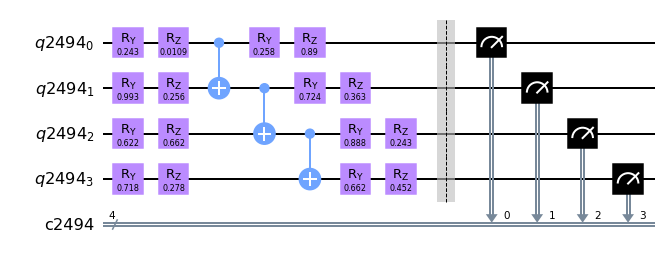

In [36]:
q_t = QuantumRegister(4)
c_t = ClassicalRegister(4)
qc_t = QuantumCircuit(q_t,c_t)
            
ansatz_linear(qc_t,q_t,4,theta)
qc_t.barrier()
for i in range(4):
    qc_t.measure(i,i)

qc_t.draw('mpl')

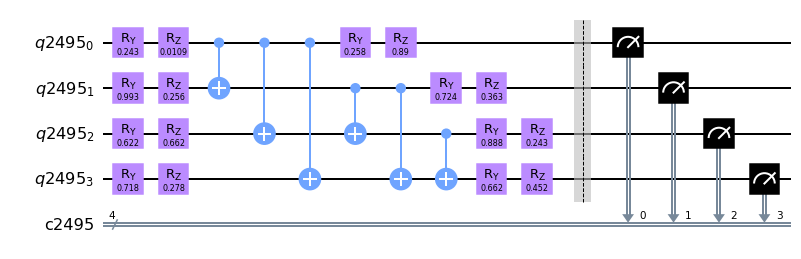

In [37]:
q_t = QuantumRegister(4)
c_t = ClassicalRegister(4)
qc_t = QuantumCircuit(q_t,c_t)
            
ansatz_full_ent(qc_t,q_t,4,theta)
qc_t.barrier()
for i in range(4):
    qc_t.measure(i,i)

qc_t.draw('mpl')

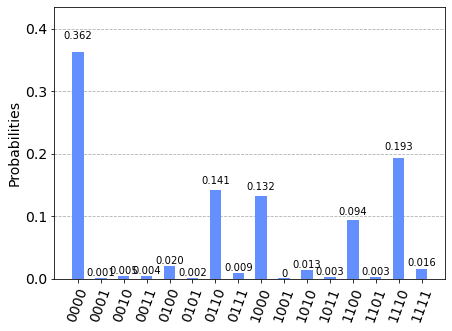

In [38]:
shots = 8000
qasm_sim = Aer.get_backend('qasm_simulator')
qjob_test = assemble(qc_t, shots = shots)
results_test = qasm_sim.run(qjob_test).result()
plot_histogram(results_test.get_counts())